Training a Deep Convolutional GAN (DCGAN) to generate fake images of clothing(that look real)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
from tensorflow.keras import layers

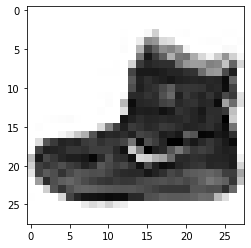

In [ ]:

(x_train,y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.shape
x_train = (x_train.astype(np.float32) - 127.5)/127.5
x_test = (x_test.astype(np.float32) - 127.5)/127.5
plt.imshow(x_train[0], cmap='Greys')

BATCH_SIZE = 256
train_batches = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
z_dim=100

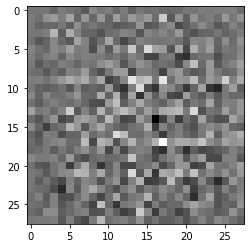

In [ ]:
def create_generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(z_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))

    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))

    model.add(layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh'))
    return model

generator = create_generator()

noise = tf.random.normal([1, 100])
generated_img = generator(noise, training=False)

plt.imshow(generated_img[0,:,:,0], cmap='gray')

In [ ]:
def create_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=[28,28,1]))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = create_discriminator()
result= discriminator(generated_img)
print(result)

tf.Tensor([[-0.00206914]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def disc_loss(real_op, fake_op):
    real_loss = cross_entropy(tf.ones_like(real_op), real_op)
    fake_loss = cross_entropy(tf.zeros_like(fake_op), fake_op)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def gene_loss(fake_op):
    return cross_entropy(tf.ones_like(fake_op), fake_op)

In [ ]:
optimizer_g = tf.keras.optimizers.Adam(1e-4)
optimizer_d = tf.keras.optimizers.Adam(1e-4)

In [ ]:
epochs=50
z_dim = 100
examples=16
seed = tf.random.normal([examples,z_dim])

In [ ]:
#Training the Model+ Update using Loss+optim

In [ ]:
def train(Data_set):
    g_loss_hist=[]
    d_loss_hist=[]

    for epoch in range(epochs):
        GLoss=0
        DLoss=0
        
        for imagebatch in Data_set:
                noise = tf.random.normal([BATCH_SIZE, z_dim])

                with tf.GradientTape() as g, tf.GradientTape() as d:
                    generated_img = generator(noise, training=True)

                    real_op = discriminator(imagebatch, training=True) 
                    fake_op = discriminator(generated_img, training=True)

                    g_loss = gene_loss(fake_op)                                                     #loss using cross-entropy
                    d_loss = disc_loss(real_op, fake_op)

                    GLoss+=float(g_loss)
                    DLoss+=float(d_loss)

                gradient_generator = g.gradient(g_loss, generator.trainable_variables)
                gradient_discriminator = d.gradient(d_loss, discriminator.trainable_variables)
                                                                                                   
                optimizer_g.apply_gradients(zip(gradient_generator, generator.trainable_variables)) #update using optimizer-Adam
                optimizer_d.apply_gradients(zip(gradient_discriminator, discriminator.trainable_variables))

        if (epoch ==9 or epoch==29 or epoch==49): 
            print("Epoch Number:{} ".format(epoch+1))  
            sample_images(generator, seed)

        g_loss_hist.append( GLoss/len(imagebatch))
        d_loss_hist.append( DLoss/len(imagebatch))

    return g_loss_hist,d_loss_hist         

In [ ]:
#outputs the fake images
def sample_images(model, inp):
    pred_value = model(inp, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(pred_value.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(pred_value[i, :, :, 0] * 127.5 + 127.5, cmap='gray')      
    plt.show()

Epoch Number:10 


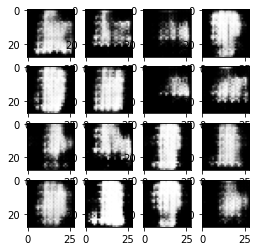

Epoch Number:30 


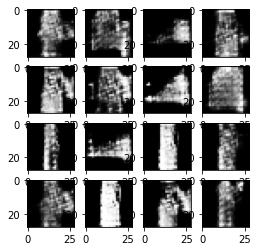

Epoch Number:50 


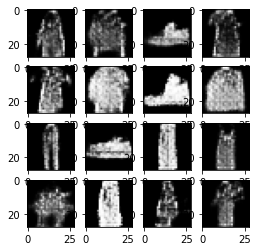

In [ ]:
gen_loss,dis_loss=train(train_batches)#actual train


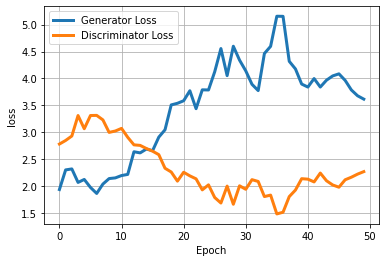

In [ ]:
plt.plot(range(50),gen_loss,'-',linewidth=3,label='Generator Loss')
plt.plot(range(50),dis_loss,'-',linewidth=3,label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

The Generator and discriminator are competing against each other, hence improvement on the one means the higher loss on the other, until this other learns better on the received loss. 
So as the generator gets better at generating real-like fake images, and reduces its loss, the discriminator has an opposite effect as it cannot distinguish between the real and fake images well anymore.
If loss has not converged very well, it doesn't necessarily mean that the model hasn't learned anything as you can see here in the generated sample images. We can increase the number of epochs to see if the losses converge.